# Bonus task - LSTM implementation

In [34]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt
!{sys.executable} -m pip install --user https://download.pytorch.org/whl/cpu/torch-1.1.0-cp37-cp37m-win_amd64.whl
!{sys.executable} -m pip install --user https://download.pytorch.org/whl/cpu/torchvision-0.3.0-cp37-cp37m-win_amd64.whl

  Using cached https://files.pythonhosted.org/packages/40/f2/a424d4d5dd6aa8c26636969decbb3da1c01286d344e71429b1d648bccb64/Pillow-6.0.0-cp37-cp37m-win_amd64.whl


In [22]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix

from utils import read_datasets, get_score, plot_anomalies
import numpy as np

## Read datasets

In [23]:
scaled_df1, train_y1, scaled_df2, train_y2, scaled_test_df, y = read_datasets()

## Set network parameters

In [24]:
# Set parameters
# torch.cuda.set_device(0)

input_size = scaled_test_df.shape[1]

# Data params
batch_size = scaled_df1.shape[0]

# LSTM reads in one timestep at a time.
lstm_input_size = 1

# size of hidden layers
h1 = 32
output_dim = 1
num_layers = 3
learning_rate = 1e-3
num_epochs = 100
dtype = torch.float

## Convert datasets to Tensors

In [25]:
# make training and test sets in torch
X_train = torch.from_numpy(scaled_df1.to_numpy()).type(torch.Tensor)
X_val = torch.from_numpy(scaled_df2.to_numpy()).type(torch.Tensor)
X_test = torch.from_numpy(scaled_test_df.to_numpy()).type(torch.Tensor)
y_train = torch.from_numpy(train_y1.to_numpy()).type(torch.Tensor).view(-1)
y_val = torch.from_numpy(train_y2.to_numpy()).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y.to_numpy()).type(torch.Tensor).view(-1)

X_train = X_train.view(scaled_df1.shape[1], scaled_df1.shape[0])
X_val = X_val.view(scaled_df2.shape[1], scaled_df2.shape[0])
X_test = X_test.view(scaled_test_df.shape[1], scaled_test_df.shape[0])

## Build LSTM model

In [26]:
# Define model
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                 num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self, x):
        return (torch.zeros(self.num_layers, x.shape[0], self.hidden_dim),
                torch.zeros(self.num_layers, x.shape[0], self.hidden_dim))
    
    # forward pass through LSTM layer
    def forward(self, x):
        self.hidden = self.init_hidden(x)

        lstm_out, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], -1))

        y_pred = self.linear(lstm_out[-1].view(x.shape[1], -1))
        return y_pred.view(-1)



## Create LSTM

In [27]:
model = LSTM(lstm_input_size, h1, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(reduction='sum')

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train model

In [28]:
# Train model

hist = np.zeros(num_epochs)
prediction_list = []
prediction_list_val = []

for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    # if epoch % 100 == 0:
    #     print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
    running_loss_train = loss.item()
    print('Epoch {} Train Loss:{}'.format(epoch + 1, running_loss_train))


Epoch 1 Train Loss:59.74062728881836
Epoch 2 Train Loss:37.574398040771484
Epoch 3 Train Loss:20.408443450927734
Epoch 4 Train Loss:8.416611671447754
Epoch 5 Train Loss:1.6961416006088257
Epoch 6 Train Loss:0.05685998126864433
Epoch 7 Train Loss:2.465566396713257
Epoch 8 Train Loss:6.440132141113281
Epoch 9 Train Loss:9.239053726196289
Epoch 10 Train Loss:9.78507137298584
Epoch 11 Train Loss:8.47361946105957
Epoch 12 Train Loss:6.210906505584717
Epoch 13 Train Loss:3.829271078109741
Epoch 14 Train Loss:1.8796255588531494
Epoch 15 Train Loss:0.6158633232116699
Epoch 16 Train Loss:0.05760292708873749
Epoch 17 Train Loss:0.07455842196941376
Epoch 18 Train Loss:0.46523675322532654
Epoch 19 Train Loss:1.0183701515197754
Epoch 20 Train Loss:1.554098129272461
Epoch 21 Train Loss:1.9461455345153809
Epoch 22 Train Loss:2.1282074451446533
Epoch 23 Train Loss:2.088857889175415
Epoch 24 Train Loss:1.8595614433288574
Epoch 25 Train Loss:1.4996758699417114
Epoch 26 Train Loss:1.0812042951583862
Epoc

## Plot precision and recall for different threshold values

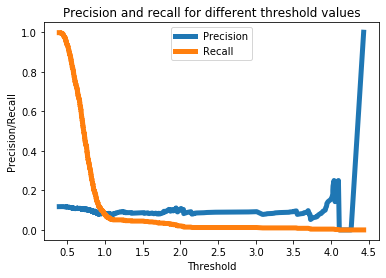

In [29]:
# Plot preds and performance
# base on https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098

valid_x_predictions = model(X_val)
mse = np.mean(np.power(X_val.detach().numpy() - valid_x_predictions.detach().numpy(), 2), axis=0)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_val == 1})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
# plt.show()
plt.savefig('plots/lstm/pre_rec.png', bbox_inches='tight')


## Plot reconstruction error for the two classes

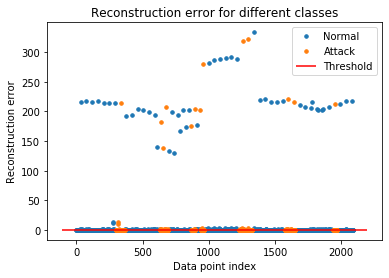

In [30]:
# based on https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
threshold = 1


test_x_predictions = model(X_test)
mse = np.mean(np.power(X_test.detach().numpy() - test_x_predictions.detach().numpy(), 2), axis=0)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y})
error_df_test = error_df_test.reset_index()

groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
# plt.show()
plt.savefig('plots/lstm/diff_classes.png', bbox_inches='tight')



## Scores

In [32]:
predicted_anomalies = np.where(error_df.Reconstruction_error.values > threshold)[0]
true_anomalies = np.where(error_df_test.True_class.values > 0)[0]
[tp, fp, fn, tn, tpr, tnr, Sttd, Scm, S] = get_score(predicted_anomalies, true_anomalies, y=y)
print("TP: {0}, FP: {1}, TPR: {2}, TNR: {3}".format(tp, fp, tpr, tnr))
print("Sttd: {0}, Scm: {1}, S: {2}".format(Sttd, Scm, S))

TP: 42, FP: 428, TPR: 0.10319410319410319, TNR: 0.7455410225921522
Sttd: 0.7161248122077615, Scm: 0.42436756289312766, S: 0.5702461875504445
